In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# few of the imports are just for checking while coding not included in the rest of notebook.

# Most basic stuff for EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.
import string
import re

# Libraries for text preprocessing.
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords


# Loading some sklearn packaces for modelling.
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation, NMF # not actively using
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Utility
import logging
import itertools


# Core packages for general use throughout the notebook.
import random
import warnings
import time
import datetime

# For customizing our plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# for build our model
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

# Setting some options for general use.
import os
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"

In [ ]:
# Read the data
df = pd.read_csv('/content/drive/MyDrive/training.1600000.processed.noemoticon.csv',encoding = DATASET_ENCODING, names=DATASET_COLUMNS)

In [ ]:
# Raw data
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [ ]:
#map target label to string
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 533 ms, sys: 7.69 ms, total: 541 ms
Wall time: 547 ms


In [ ]:
#Cleaning Test
# Some basic helper functions to clean text by removing urls, emojis, html tags and punctuations.
def remove_stopwords(text):
    tokens = []
    for token in text.split():
        if token not in stop:
            tokens.append(token)
    return " ".join(tokens)


def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions
df['text_clean'] = df['text'].apply(lambda x: remove_stopwords(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_URL(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punct(x))

In [ ]:
df.head()

,target,ids,date,flag,user,text,text_clean
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D",switchfoot Awww thats bummer You shoulda got David Carr Third Day it D
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,upset cant update Facebook texting it might cry result School today also Blah
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds,Kenichan I dived many times ball Managed save 50 The rest go bounds
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.",nationwideclass no behaving all im mad here I cant see there


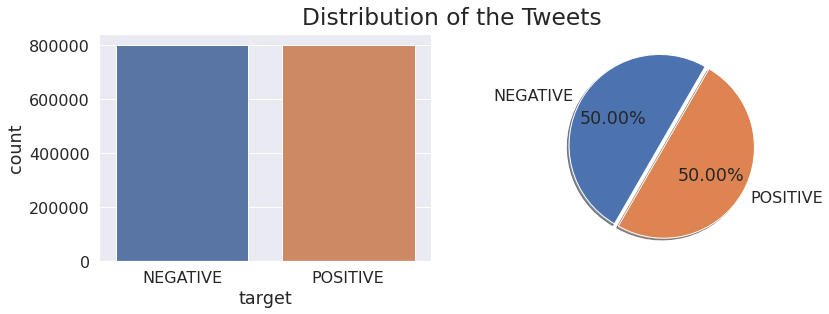

In [ ]:
# Visualizing The Data
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), dpi=70)
sns.countplot(df['target'], ax=axes[0])
axes[1].pie(df['target'].value_counts(),
            labels=[NEGATIVE, POSITIVE],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

In [ ]:
# Creating a new feature for the visualization.

df['Character Count'] = df['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df_x, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df_x.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

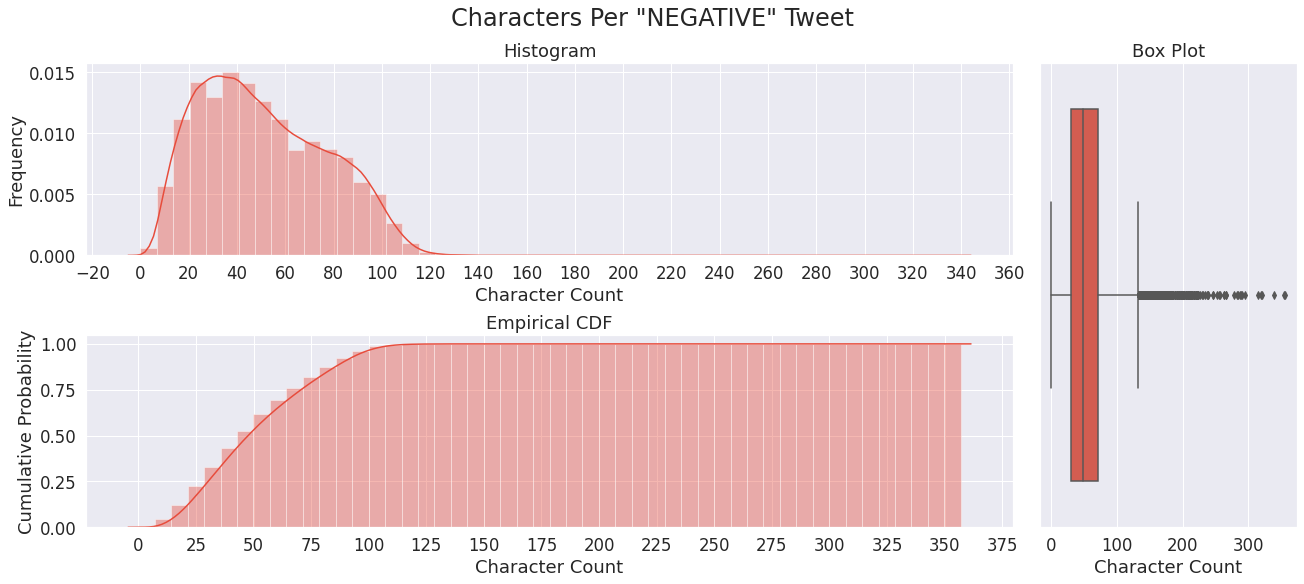

In [ ]:
plot_dist3(df[df['target'] == 'NEGATIVE'], 'Character Count','Characters Per "NEGATIVE" Tweet')

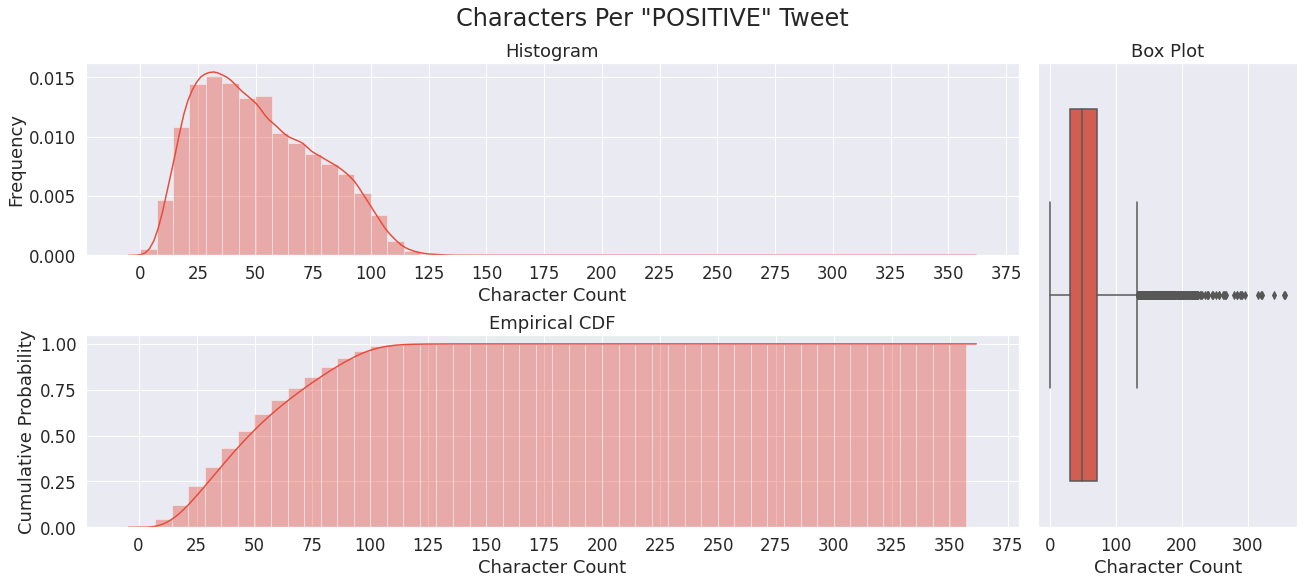

In [ ]:
plot_dist3(df[df['target'] == "POSITIVE"], 'Character Count','Characters Per "POSITIVE" Tweet')

In [ ]:
#setup Environment to build model
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [ ]:
# hyperparameters
max_length = 140 # max length of tweets in the dataset collection time
batch_size = 512 # huge batch_size is used because it affects training time significantly. /we have really big dataset/

In [ ]:
# Bert Tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
#Splitting the data
train_df, test = train_test_split(df, test_size=0.01, random_state=42)
x_train, dev = train_test_split(train_df, test_size=0.01, random_state=42)

In [ ]:
print(x_train.shape)
print(test.shape)
print(dev.shape)

(1568160, 8)
(16000, 8)
(15840, 8)


In [ ]:
#data decrease
train = x_train[:500000]

In [ ]:
#label Encoder
labels = train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(train.target.tolist())

y_train = encoder.transform(train.target.tolist())
y_test = encoder.transform(test.target.tolist())
y_dev = encoder.transform(dev.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_dev = y_dev.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (500000, 1)
y_test (16000, 1)


In [ ]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [ ]:
train_encoded = bert_encode(train.text_clean)
dev_encoded = bert_encode(dev.text_clean)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(128)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, y_dev))
    .shuffle(128)
    .batch(batch_size)
)

In [ ]:
#proposed Model
def bert_model():

    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]
    x = tf.keras.layers.SpatialDropout1D(0.2)(last_hidden_states)
    x = tf.keras.layers.Conv1D(32, 3, activation='relu')(x)
    x = tf.keras.layers.Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2))(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(input_word_ids, outputs)
    
    return model

In [ ]:
with strategy.scope():
    model = bert_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

    model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 140)]             0         
                                                                 
 tf_bert_model_2 (TFBertMode  TFBaseModelOutputWithPoo  109482240
 l)                          lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             140, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

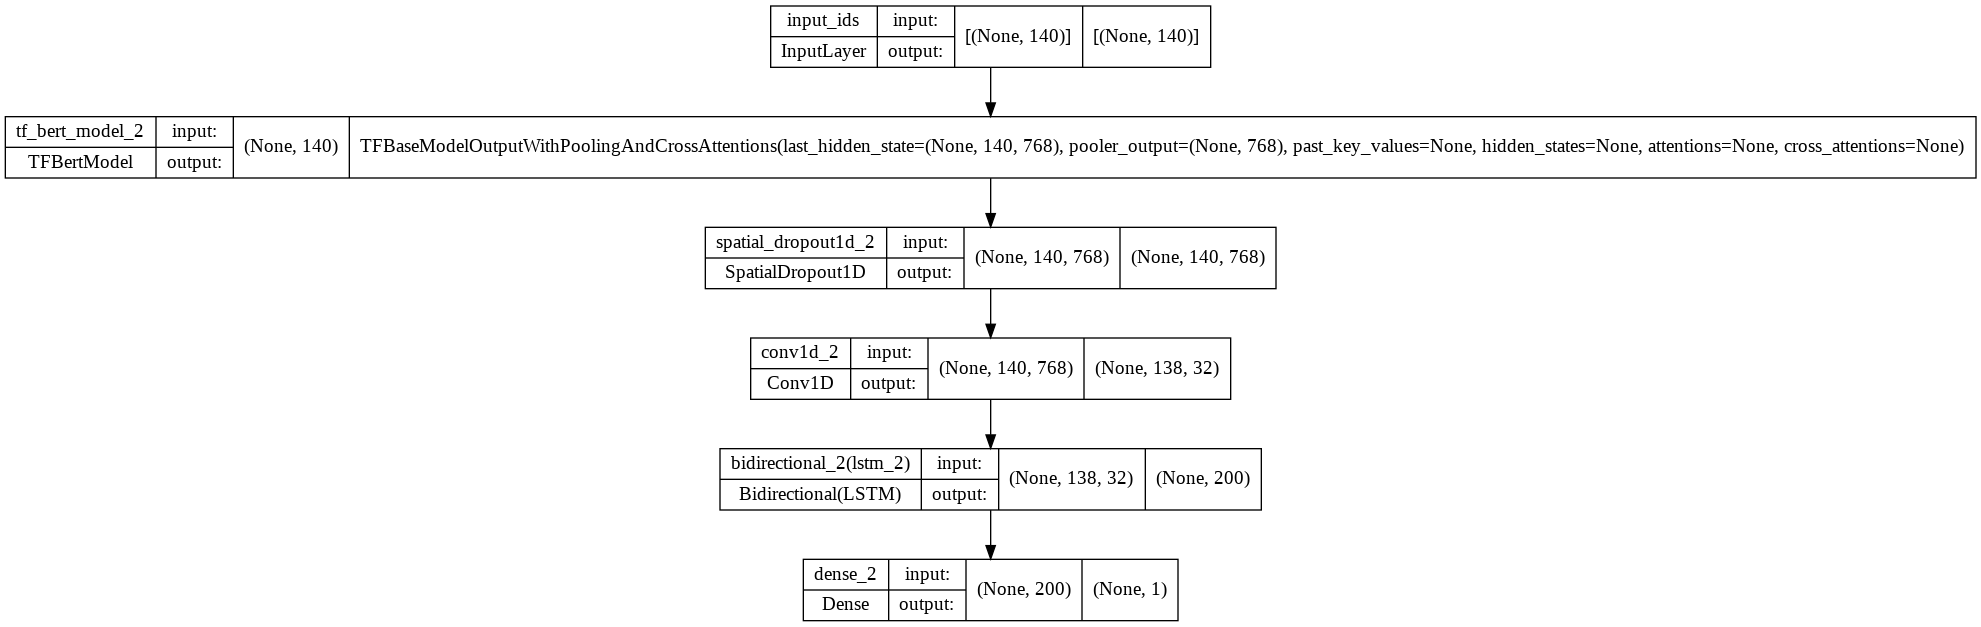

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-5, patience=5)]

In [ ]:
# Start train
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=3,
    validation_data=dev_dataset,
    verbose=1,
    callbacks = callbacks)

Epoch 1/3


977/977 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.7928

977/977 [==============================] - 734s 646ms/step - loss: 0.4399 - accuracy: 0.7928 - val_loss: 0.4108 - val_accuracy: 0.8112 - lr: 1.0000e-04
Epoch 2/3
977/977 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.8372

977/977 [==============================] - 551s 564ms/step - loss: 0.3656 - accuracy: 0.8372 - val_loss: 0.4199 - val_accuracy: 0.8115 - lr: 1.0000e-04
Epoch 3/3
977/977 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 0.8734

977/977 [==============================] - 551s 564ms/step - loss: 0.2998 - accuracy: 0.8734 - val_loss: 0.4824 - val_accuracy: 0.8071 - lr: 1.0000e-04


In [ ]:
# SAVE MODEL WEIGHTS
model.save_weights(f'sentiment_weights_v1.h5')

In [ ]:
# LOAD MODEL WEIGHTS
#model.load_weights('../input/-THE PATH THAT YOU UPLOADED WEIGHTS ON KAGGLE-/sentiment_weights_v1.h5')

#to be able to use weights you need to run same model again without fitting because you need model to get weights:) 

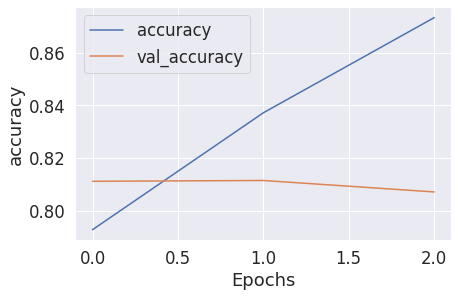

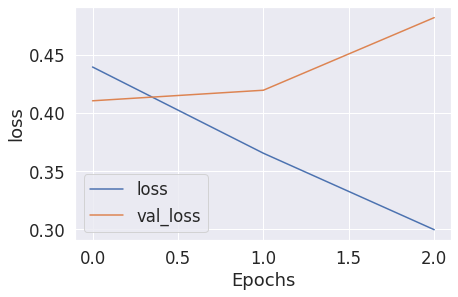

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
   
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
#Predict Manually Before Using Test Data
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=False):
    start_at = time.time()
    # Tokenize text
    x_encoded = bert_encode([text])
    # Predict
    score = model.predict([x_encoded])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I hate the economy")

{'label': 'NEGATIVE',
 'score': 0.003399401903152466,
 'elapsed_time': 11.140342473983765}

In [ ]:
predict("I would prefer writing a crawler to create this dataset but i couldn't", True)

{'label': 'NEGATIVE',
 'score': 0.00814107060432434,
 'elapsed_time': 1.085925817489624}

In [ ]:
predict("I LOVE NLP")

{'label': 'POSITIVE',
 'score': 0.9825032949447632,
 'elapsed_time': 0.8919308185577393}

In [ ]:
predict("life is really strange isn't it? just the combination of laugh and cry", True)

{'label': 'POSITIVE',
 'score': 0.7086839079856873,
 'elapsed_time': 0.6469728946685791}

In [ ]:
predict("ESL is the world's largest esports company, leading the industry across the most popular video games.\
        We're proud they've chosen us to help them deliver their launchers to gamers all over the world. Read the full review")

{'label': 'POSITIVE',
 'score': 0.9977719783782959,
 'elapsed_time': 0.6747963428497314}

In [ ]:
predict("Excited to present a tutorial on 'Modular and Parameter-Efficient Fine-Tuning for NLP Models' \
        at #EMNLP2022 with @PfeiffJo & @licwu.")

{'label': 'POSITIVE',
 'score': 0.9977645874023438,
 'elapsed_time': 0.6376948356628418}

In [ ]:
predict("Had a song stuck in my head. Thirty seconds later I'm listening to it, thanks to the internet,\
        and Apple/YouTube Music. In the bad old days I'd browse record stores for hours in the hope that the title might jog my memory.\
        It really is a wonderful time to be alive!")

{'label': 'POSITIVE',
 'score': 0.9056941270828247,
 'elapsed_time': 0.6453030109405518}

In [ ]:
predict("i don't say this lightly - hemingway's life ended by suicide. His life was actually a loss")

{'label': 'NEGATIVE',
 'score': 0.11851280927658081,
 'elapsed_time': 0.619044303894043}

In [ ]:
predict("these r not ur problems dear!!! these r ur x bf's commitng suicide")

{'label': 'NEGATIVE',
 'score': 0.03293368220329285,
 'elapsed_time': 0.6576259136199951}

In [ ]:
predict("i hve no idea about i love the uni or not", True)


{'label': 'POSITIVE',
 'score': 0.8089255094528198,
 'elapsed_time': 0.6387238502502441}

In [ ]:
predict("For the third time in four years, the Warriors are champions once again.\
This time, they wasted no time in the NBA Finals, dispatching LeBron James and the Cavs in four straight games.\
Here’s how they sealed the championship in Game 4. https://twitter.com/i/moments/1005197277663641600")

{'label': 'NEGATIVE',
 'score': 0.021906018257141113,
 'elapsed_time': 0.6058216094970703}

In [ ]:
predict("I found some old Reddit post in which one guy from english-speaking country complains that\
the names in The Witcher books are 'too difficult' and non- intuitive for english speaker.\
Man, let me introduce you to 'The books werent written only/for english speakers.'' #witcher")

{'label': 'NEGATIVE',
 'score': 0.05124947428703308,
 'elapsed_time': 0.6526548862457275}

In [ ]:
predict("I forgot how cringy all the Slavic names sound read it English \
YOU'RE PRONOUNCING IT ALL WRONG MY EARS ARE HURTING AND I DON'T EVEN HAVE HEARING AIDS IN")

{'label': 'NEGATIVE',
 'score': 0.016166985034942627,
 'elapsed_time': 0.6346721649169922}

In [ ]:
predict("fun fact: ai cannot predict everything right")

{'label': 'NEGATIVE',
 'score': 0.41261401772499084,
 'elapsed_time': 0.573021411895752}

In [ ]:
predict("brain is just machine", True)

{'label': 'NEUTRAL',
 'score': 0.44933250546455383,
 'elapsed_time': 0.5836713314056396}

In [ ]:
#Test Results
test_encoded = bert_encode(test.text_clean)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_encoded)
    .batch(batch_size)
)

y_pred = []
predicted_tweets = model.predict(test_dataset, batch_size=batch_size)
predicted_tweets_binary = tf.cast(tf.round(predicted_tweets), tf.int32).numpy().flatten()

In [ ]:
%%time
scores = model.evaluate(test_encoded, y_test, batch_size=batch_size)
print()
print("ACCURACY:",scores[1])
print("LOSS:",scores[0])

32/32 [==============================] - 13s 387ms/step - loss: 0.4853 - accuracy: 0.8048

ACCURACY: 0.8047500252723694
LOSS: 0.48528164625167847
CPU times: user 1.05 s, sys: 125 ms, total: 1.17 s
Wall time: 12.9 s


In [ ]:
#To decrease our really bad guesses in old predict function
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def improved_prediction(text, include_neutral=False):
    start_at = time.time()
    # Applying helper functions
    text = remove_stopwords(text)
    text = remove_URL(text)
    text = remove_html(text)
    text = remove_punct(text)
    # Tokenize text
    x_encoded = bert_encode([text])
    # Predict
    score = model.predict([x_encoded])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
improved_prediction("life is really strange isn't it? just the combination of laugh and cry", True)

{'label': 'POSITIVE',
 'score': 0.7622103095054626,
 'elapsed_time': 0.5937619209289551}

In [ ]:
improved_prediction("For the third time in four years, the Warriors are champions once again.\
This time, they wasted no time in the NBA Finals, dispatching LeBron James and the Cavs in four straight games.\
Here’s how they sealed the championship in Game 4. https://twitter.com/i/moments/1005197277663641600")

{'label': 'NEGATIVE',
 'score': 0.47186094522476196,
 'elapsed_time': 0.5931785106658936}

In [ ]:
improved_prediction("brain is just machine", True)

{'label': 'NEGATIVE',
 'score': 0.13689348101615906,
 'elapsed_time': 0.6054263114929199}

In [ ]:
y_pred = [decode_sentiment(predicted_tweets) for predicted_tweets in scores]
y_pred

['NEGATIVE', 'POSITIVE']

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

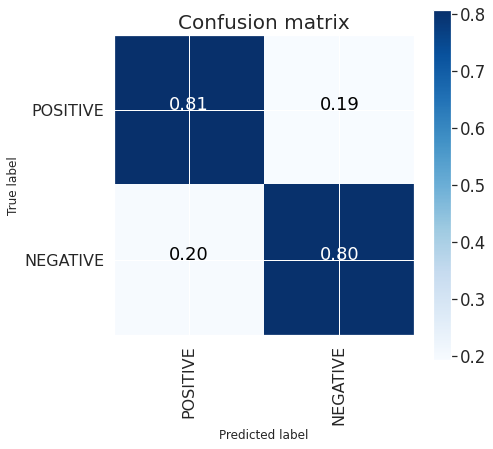

In [ ]:
cnf_matrix = confusion_matrix(y_test, predicted_tweets_binary)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
#Comprehensive Report
print('Precision: %.4f' % precision_score(y_test, predicted_tweets_binary))
print('Recall: %.4f' % recall_score(y_test, predicted_tweets_binary))
print('Accuracy: %.4f' % accuracy_score(y_test, predicted_tweets_binary))
print('F1 Score: %.4f' % f1_score(y_test, predicted_tweets_binary))
print(classification_report(y_test, predicted_tweets_binary))

Precision: 0.8067
Recall: 0.8027
Accuracy: 0.8047
F1 Score: 0.8047
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      7982
           1       0.81      0.80      0.80      8018

    accuracy                           0.80     16000
   macro avg       0.80      0.80      0.80     16000
weighted avg       0.80      0.80      0.80     16000



In [ ]:
#Error Analysis
decode_map = {0: "NEGATIVE", 1: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
df = pd.DataFrame(test.text, columns=["text"])
df['ids'] = test.ids
df["actual"] = test.target
df["predicted"] = predicted_tweets_binary
df.predicted = df.predicted.apply(lambda x: decode_sentiment(x))
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
incorrect = df[df["actual"] != df["predicted"]]
incorrect[10:20]

,text,ids,actual,predicted
922422,@joshlam and you are how old?? REALLY?!?,1754424886,POSITIVE,NEGATIVE
1106327,@BATYASMUSIC Don't really have a reason.. haha sounds stupid. I'll be 14,1971411001,POSITIVE,NEGATIVE
1328830,"@disil429 Fine. Kinders coughing again, so not a lot of sleep. Weather's good, though, that's the main thing",2015570824,POSITIVE,NEGATIVE
1501551,"@mithss mourniiiiiiing eh, morniiing!!!",2071479153,POSITIVE,NEGATIVE
222,"@PaulaAbdul awww, Good luck Paula!! Please don't work too hard but I hope you have fun Your new album is gonna be amazing! xxx",1467871545,NEGATIVE,POSITIVE
463022,at school...listining to die Ãrzte - Westerland...great song really..btw i'm so tired...i sleeped between 02:30 and 05:30..thats bad,2174824047,NEGATIVE,POSITIVE
1223531,i have find my someone,1990422918,POSITIVE,NEGATIVE
904643,One interlock down one to go,1694881980,POSITIVE,NEGATIVE
374134,@dbferguson I'm using an Asus. Forget which one at the moment since I don't have it near me.But my complaints are similar to yours.,2051178100,NEGATIVE,POSITIVE
1274615,"@powersurf OH I've Got a case. I designed it. Someone idiot stole it and I can prove it. If they want to play hardball,I'm game.",2000986359,POSITIVE,NEGATIVE


In [ ]:
scorrect = df[df['actual'] == df['predicted']]
correct.head(10)

,text,ids,actual,predicted
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,2200003196,NEGATIVE,NEGATIVE
766711,"@TiannaChaos i know just family drama. its lame.hey next time u hang out with kim n u guys like have a sleepover or whatever, ill call u",2300048954,NEGATIVE,NEGATIVE
285055,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(,1993474027,NEGATIVE,NEGATIVE
705995,upper airways problem,2256550904,NEGATIVE,NEGATIVE
379611,Going to miss Pastor's sermon on Faith...,2052380495,NEGATIVE,NEGATIVE
1189018,on lunch....dj should come eat with me,1983449090,POSITIVE,POSITIVE
667030,@piginthepoke oh why are you feeling like that?,2245479748,NEGATIVE,NEGATIVE
93541,gahh noo!peyton needs to live!this is horrible,1770705699,NEGATIVE,NEGATIVE
1097326,@mrstessyman thank you glad you like it! There is a product review bit on the site Enjoy knitting it!,1970386589,POSITIVE,POSITIVE
1495501,@k9wkj Great minds think alike,2069921255,POSITIVE,POSITIVE
